![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest gap-filling
</b>
</span>

---
**Notebook version**: `2` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using random forest to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [3]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [4]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.74.0


</br>

# **Docstring** for `RandomForestTS`

In [5]:
# help(RandomForestTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [6]:
source_df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.054 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [7]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [8]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445
std,6.085449,7.548653,3.710180,247.531312
min,-38.653000,-23.096000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000
75%,0.606250,10.067000,4.375000,225.677750
max,25.290000,28.713000,32.118000,1197.800000


In [9]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
SD,6.085449
VAR,37.032694
SD/MEAN,-1.58743


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


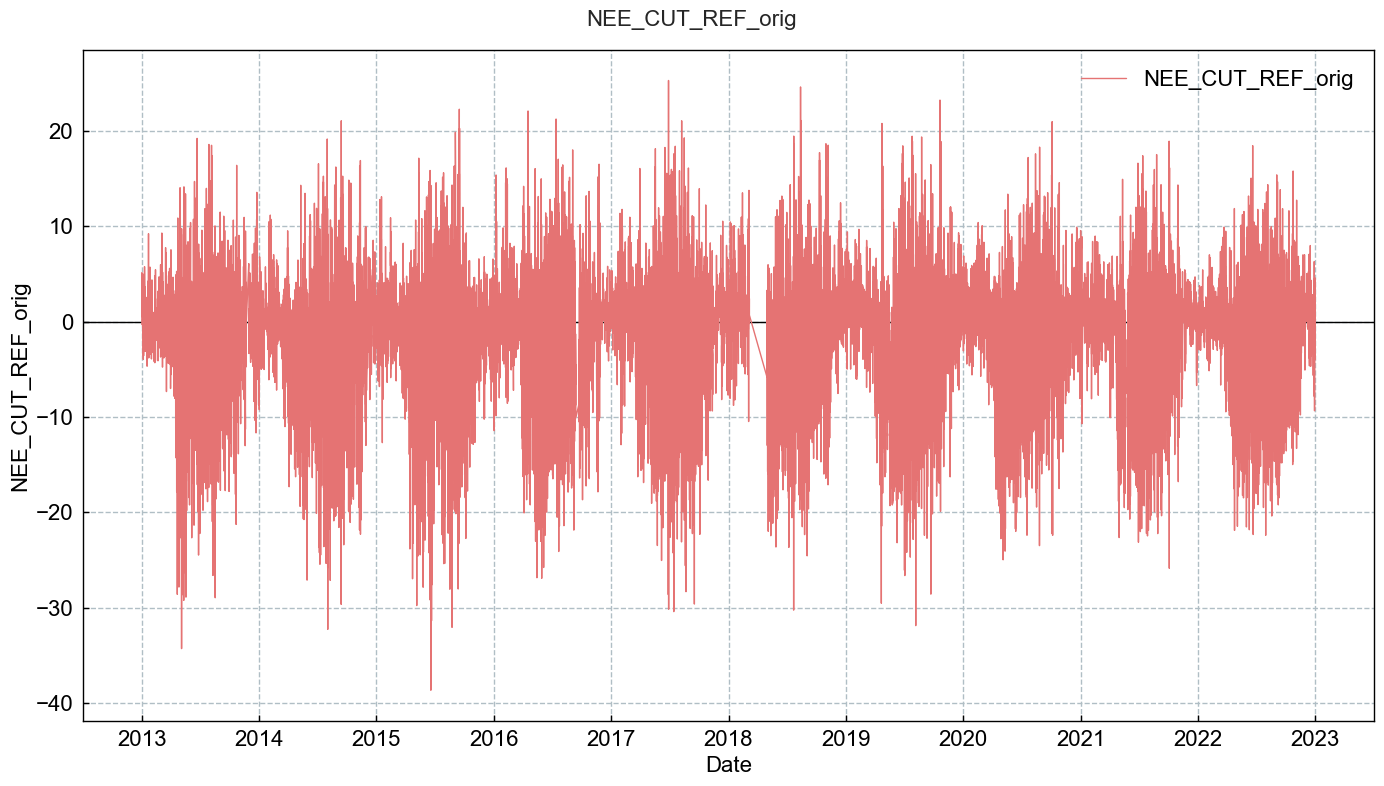

In [10]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize random forest

In [11]:
# Random forest
rfts = RandomForestTS(
    input_df=df,
    target_col=TARGET_COL,
    verbose=1,    
    features_lag=[-1, -1],    
    include_timestamp_as_features=True,    
    add_continuous_record_number=True,
    sanitize_timestamp=True,
    n_estimators=99,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    perm_n_repeats=33,
    n_jobs=-1
)


Creating lagged variants ...
Created lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f'] (lags between -1 and -1 with stepsize 1)
No lagged variants for: ['NEE_CUT_REF_orig']

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
Sorting timestamp TIMESTAMP_MIDDLE ascending ... Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ... 

</br>

## Feature reduction

In [12]:
rfts.reduce_features()

Feature reduction ...


In [13]:
rfts.report_feature_reduction()


FEATURE REDUCTION

- the random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances
- target variable: NEE_CUT_REF_orig
- features before reduction: ['Rg_f', '.DOY', '.Tair_f-1', 'Tair_f', '.HOUR', '.Rg_f-1', '.VPD_f-1', 'VPD_f', '.RECORDNUMBER', '.WEEK', '.YEARDOY', '.YEARMONTH', '.YEARWEEK', '.SEASON', '.MONTH', '.YEAR', '.RANDOM']
- permutation importance was calculated from 33 permutations
- These results are from feature reduction. Note that feature importances for the final model are calculated during gap-filling.


PERMUTATION IMPORTANCE (FULL RESULTS):

               PERM_IMPORTANCE   PERM_SD
Rg_f                  1.145631  0.015387
.DOY                  0.159656  0.004919
.Tair_f-1             0.097409  0.002135
Tair_f                0.091158  0.002966
.HOUR                 0.069200  0.002798
.Rg_f-1               0.059398  0.001823
.VPD_f-1              0.055077  0.001578
VPD_f                 0.024211  0.001079


</br>

## Train model

Building random forest model based on data between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\pkgs\gapfilling\randomforest_ts.py:708: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


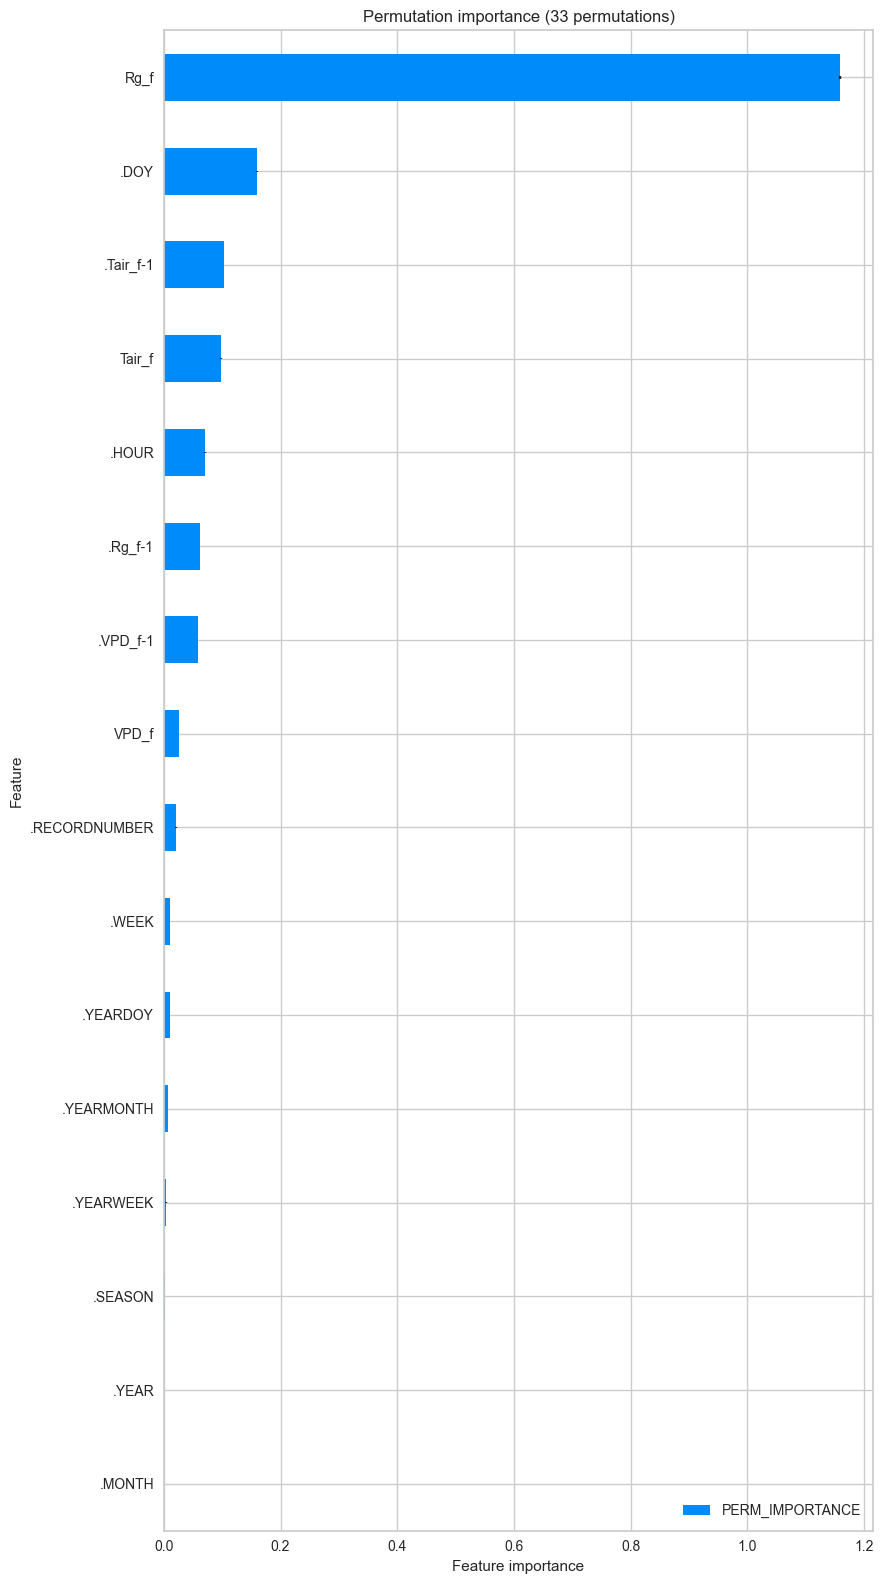

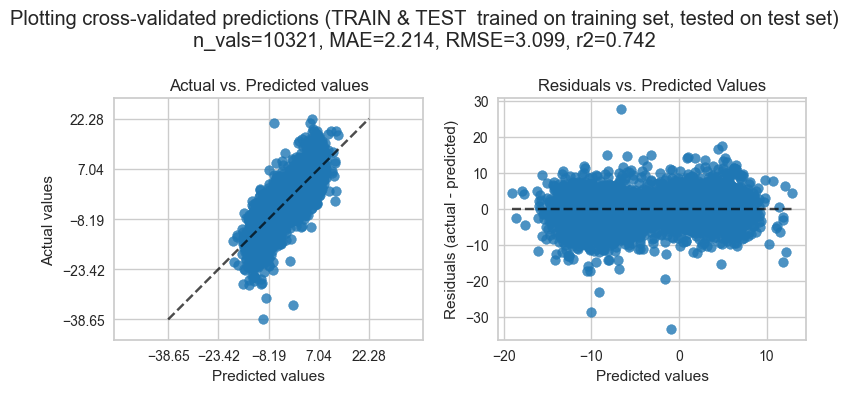

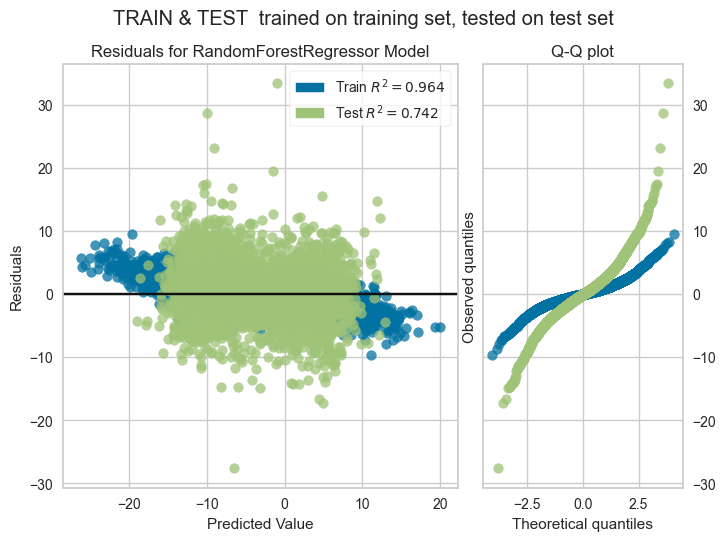

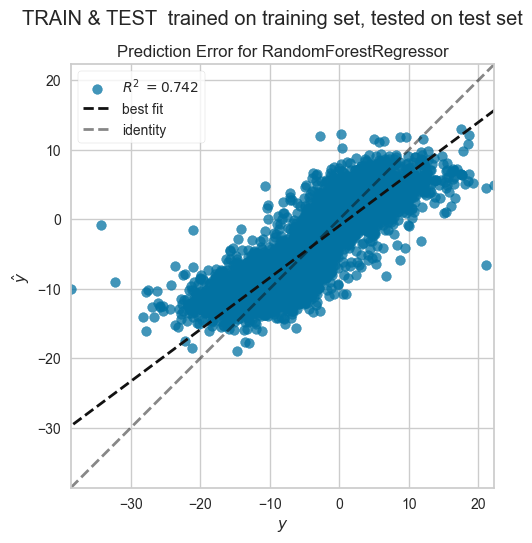

In [14]:
rfts.trainmodel(showplot_scores=True, showplot_importance=True)

In [15]:
rfts.report_traintest()


MODEL TRAINING & TESTING RESULTS

- the model was trained and tested based on data between 2013-01-01T01:45:00.000000000 and 2022-12-31T22:15:00.000000000.
- in total, 41284 observed target values were available for training and testing
- the dataset was split into training and test datasets
  > the training dataset comprised 30963 target values (75.0%)
  > the test dataset comprised 10321 target values (25.0%)

## FEATURE IMPORTANCES
- feature importances were calculated for test data (10321 target values).
- permutation importances were calculated from 33 repeats.
               PERM_IMPORTANCE   PERM_SD
Rg_f                  1.157828  0.015136
.DOY                  0.159497  0.004635
.Tair_f-1             0.103933  0.002471
Tair_f                0.097881  0.003009
.HOUR                 0.071076  0.002641
.Rg_f-1               0.062470  0.001778
.VPD_f-1              0.058256  0.001684
VPD_f                 0.025811  0.001181
.RECORDNUMBER         0.020964  0.000895
.WEEK           

</br>

## Apply model to fill gaps

F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\pkgs\gapfilling\randomforest_ts.py:708: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


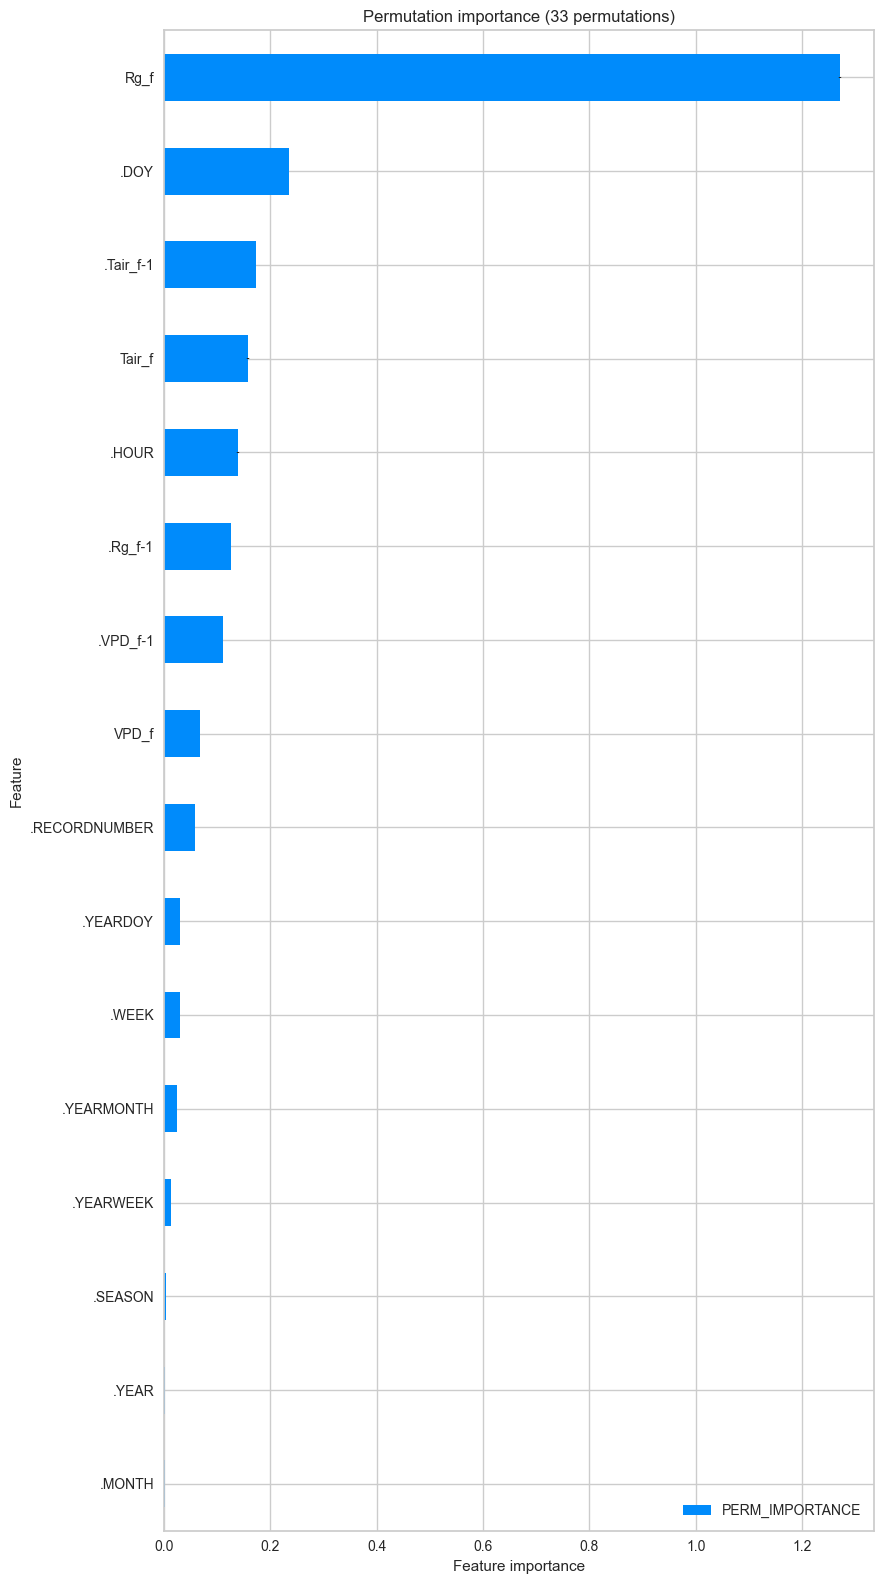

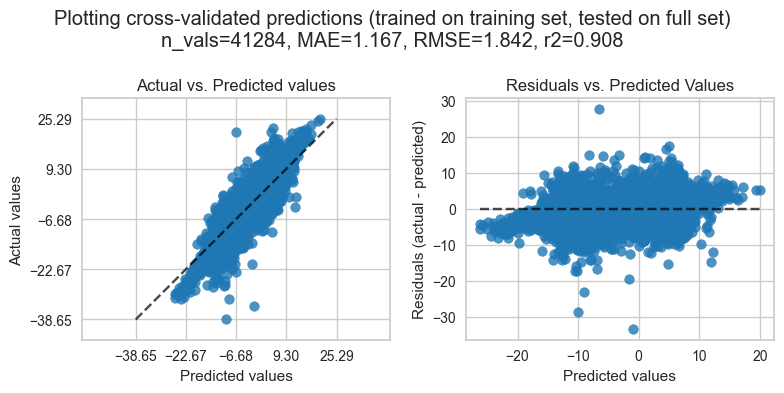


Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)


In [16]:
rfts.fillgaps(showplot_scores=True, showplot_importance=True)

In [17]:
rfts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (134011 values, NEE_CUT_REF_orig_gfRF where flag=1) in comparison to observed targets (41284 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  134012 (cross-check from flag: 134012)
- target column (gap-filled):  NEE_CUT_REF_orig_gfRF  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED
  > flag 0 ... observed targets (41284 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (134011 values)
  > flag 2 ... targets gap-filled with fallback (1 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', '.DOY', '.Tair_f-1', 'Tair_f', '.HOUR', '.Rg_f-1', '.VPD_f-1', 'VPD_f', '.RECORDNUMBER', '

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [18]:
rfts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.271749,0.008187
.DOY,0.234930,0.002269
.Tair_f-1,0.172890,0.001412
Tair_f,0.158680,0.001605
.HOUR,0.139552,0.001851
.Rg_f-1,0.126151,0.001115
.VPD_f-1,0.111836,0.000824
VPD_f,0.068048,0.000667
.RECORDNUMBER,0.057875,0.000499
.YEARDOY,0.030772,0.000241


In [19]:
rfts.feature_importances_reduction_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.145631,0.015387
.DOY,0.159656,0.004919
.Tair_f-1,0.097409,0.002135
Tair_f,0.091158,0.002966
.HOUR,0.069200,0.002798
.Rg_f-1,0.059398,0.001823
.VPD_f-1,0.055077,0.001578
VPD_f,0.024211,0.001079
.RECORDNUMBER,0.019431,0.000770
.WEEK,0.010565,0.000572


In [20]:
rfts.feature_importances_traintest_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.157828,0.015136
.DOY,0.159497,0.004635
.Tair_f-1,0.103933,0.002471
Tair_f,0.097881,0.003009
.HOUR,0.071076,0.002641
.Rg_f-1,0.062470,0.001778
.VPD_f-1,0.058256,0.001684
VPD_f,0.025811,0.001181
.RECORDNUMBER,0.020964,0.000895
.WEEK,0.011449,0.000738


In [21]:
rfts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,0.957572,0.957572,0.957572,0.957572
2013-01-01 00:45:00,0.888980,NaN,0.888980,1.0,0.888980,0.957572,1.846551,0.888980
2013-01-01 01:15:00,0.934677,NaN,0.934677,1.0,0.934677,0.745832,2.781228,0.934677
2013-01-01 01:45:00,0.952768,0.538,NaN,0.0,0.538000,0.745832,3.319228,0.952768
2013-01-01 02:15:00,0.020424,NaN,0.020424,1.0,0.020424,0.415205,3.339652,0.020424
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.725667,NaN,2.725667,1.0,2.725667,3.349048,-61447.296560,2.725667
2022-12-31 22:15:00,2.879303,3.518,NaN,0.0,3.518000,2.875265,-61443.778560,2.879303
2022-12-31 22:45:00,2.114768,NaN,2.114768,1.0,2.114768,2.875265,-61441.663792,2.114768


In [22]:
rfts.model_

RandomForestRegressor(n_estimators=99, n_jobs=-1, random_state=42)

In [23]:
rfts.accepted_features_

['Rg_f',
 '.DOY',
 '.Tair_f-1',
 'Tair_f',
 '.HOUR',
 '.Rg_f-1',
 '.VPD_f-1',
 'VPD_f',
 '.RECORDNUMBER',
 '.WEEK',
 '.YEARDOY',
 '.YEARMONTH',
 '.YEARWEEK',
 '.SEASON',
 '.MONTH',
 '.YEAR']

In [24]:
rfts.rejected_features_

['.RANDOM']

In [25]:
rfts.scores_

{'mae': 1.1667208948803998,
 'medae': 0.7274898989898988,
 'mse': 3.3940841892583227,
 'rmse': 1.8423040436524918,
 'mape': 320831871350.8655,
 'maxe': 33.37,
 'r2': 0.9083467600358465}

In [26]:
rfts.scores_test_

{'mae': 2.214316678068349,
 'medae': 1.638696969696971,
 'mse': 9.606196649514814,
 'rmse': 3.099386495665685,
 'mape': 1095113878263.4689,
 'maxe': 33.37,
 'r2': 0.7421292079986844}

In [27]:
rfts.traintest_details_.keys()

dict_keys(['X', 'y', 'timestamp', 'predictions', 'X_names', 'y_name', 'X_train', 'y_train', 'X_test', 'y_test', 'model'])

</br>

## Result

In [28]:
gapfilled = rfts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.957572
2013-01-01 00:45:00    0.888980
2013-01-01 01:15:00    0.934677
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00    0.020424
                         ...   
2022-12-31 21:45:00    2.725667
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00    2.114768
2022-12-31 23:15:00    2.911404
2022-12-31 23:45:00    4.829495
Freq: 30min, Name: NEE_CUT_REF_orig_gfRF, Length: 175296, dtype: float64

In [29]:
flag = rfts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    2.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30min, Name: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED, Length: 175296, dtype: float64

In [30]:
gapfilling_df = rfts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,0.957572,0.957572,0.957572,0.957572
2013-01-01 00:45:00,0.888980,NaN,0.888980,1.0,0.888980,0.957572,1.846551,0.888980
2013-01-01 01:15:00,0.934677,NaN,0.934677,1.0,0.934677,0.745832,2.781228,0.934677
2013-01-01 01:45:00,0.952768,0.538,NaN,0.0,0.538000,0.745832,3.319228,0.952768
2013-01-01 02:15:00,0.020424,NaN,0.020424,1.0,0.020424,0.415205,3.339652,0.020424
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2.725667,NaN,2.725667,1.0,2.725667,3.349048,-61447.296560,2.725667
2022-12-31 22:15:00,2.879303,3.518,NaN,0.0,3.518000,2.875265,-61443.778560,2.879303
2022-12-31 22:45:00,2.114768,NaN,2.114768,1.0,2.114768,2.875265,-61441.663792,2.114768


</br>

## Plot

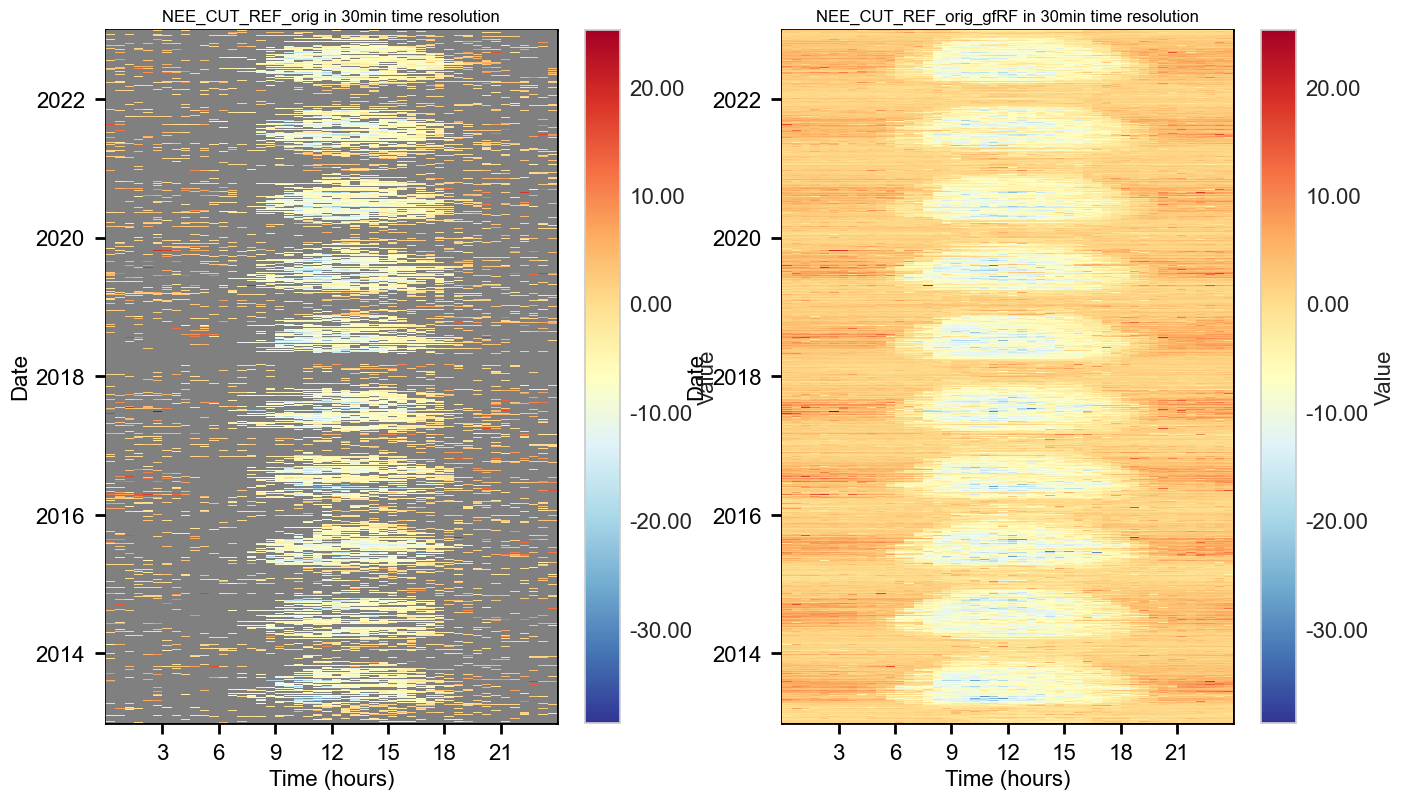

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

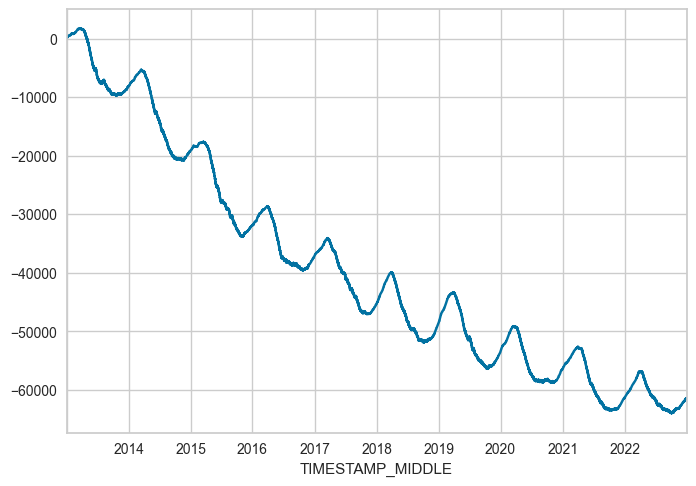

In [32]:
gapfilled.cumsum().plot();

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [33]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-04-20 18:56:16
